## Recommendations for Microsoft's New Movie Studio

In this notebook we are going to explore the relationship between the movie success and movie time of release,movie runtime, movie genre, directors, and actors/actresses. 
Success will be based on ROI and Profit margin.


First object is to clean up the movie budget dataframe, then merge all the relevant data sets so we have one dataframe
that is easy to work with.

In [6]:
#Complete cell to create money metrics df for merging
#importing stuff
import pandas as pd
import numpy as np
import matplotlib
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Load all the data.
bom_movie_gross_df = pd.read_csv('zippedData/bom.movie_gross.csv.gz')
imdb_name_basics_df = pd.read_csv('zippedData/imdb.name.basics.csv.gz')
imdb_title_akas_df = pd.read_csv('zippedData/imdb.title.akas.csv.gz')
imdb_title_basics_df = pd.read_csv('zippedData/imdb.title.basics.csv.gz')
imdb_title_crew_df = pd.read_csv('zippedData/imdb.title.crew.csv.gz')
imdb_title_principals_df = pd.read_csv('zippedData/imdb.title.principals.csv.gz')
imdb_title_ratings_df = pd.read_csv('zippedData/imdb.title.ratings.csv.gz')
rt_movie_info_df = pd.read_csv('zippedData/rt.movie_info.tsv.gz', delimiter='\t')
rt_reviews_df = pd.read_csv('zippedData/rt.reviews.tsv.gz', delimiter='\t', encoding='latin-1')
tmdb_movies_df = pd.read_csv('zippedData/tmdb.movies.csv.gz')
tn_movie_budgets_df = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')


#renaming it to work on
money_metrics_df = tn_movie_budgets_df

#funtion for cleaning
def clean_a_money_column(df, series_title):
    df[series_title] = df[series_title].str.replace('$','')
    df[series_title] = df[series_title].str.replace(',','')
    df[series_title] = pd.to_numeric(df[series_title])
    return df

#cleaning
money_metrics_df = clean_a_money_column(money_metrics_df,'worldwide_gross')
money_metrics_df = clean_a_money_column(money_metrics_df,'domestic_gross')
money_metrics_df = clean_a_money_column(money_metrics_df,'production_budget')


##Unique ID for later merging madness

money_metrics_df['mmdf_uni_id'] = money_metrics_df.index



#adding profit margin and ROI columns
money_metrics_df['Profit Margin']= round((money_metrics_df['worldwide_gross']\
                                    -money_metrics_df['production_budget'])/money_metrics_df['worldwide_gross'],3)*100
money_metrics_df['ROI'] = (money_metrics_df['worldwide_gross']/money_metrics_df['production_budget'])

#setting profit margin desc as order for the table
money_metrics_df=money_metrics_df.sort_values(['Profit Margin'], ascending=False)

#dropping the zeros gross films

money_metrics_df = money_metrics_df[money_metrics_df['worldwide_gross'] != 0]

#creating year and month columns
#Vu's magic lambda, plus to numeric on the year 
money_metrics_df['Year'] = pd.to_numeric(money_metrics_df['release_date'].map(lambda x: x[-4:]))
money_metrics_df['Month'] = money_metrics_df['release_date'].map(lambda x: x[:3])

#I did this at some point and it breaks if I don't do it here
money_metrics_df.set_index('movie', inplace = True)
money_metrics_df.index.rename('Movie', inplace = True)

#vu's dupe check
movie_dupes = pd.Series(tn_movie_budgets_df['movie'].value_counts())
title_dupes = [movie_dupes.index[index] for index in list(range(len(movie_dupes))) if movie_dupes.values[index] > 1]


#making a new df to do the rename in
title_dupes_df = money_metrics_df[money_metrics_df.index.isin(title_dupes)]

#reset the index for easier editing
title_dupes_df.reset_index(inplace = True)

title_dupes_df.head(5)

#Making new columns, setting year to string for concat
title_dupes_df['Yearasastring'] = title_dupes_df['Year'].map(lambda x: str(x))
#Making the new title by combining the name of the movie and the year of release
title_dupes_df['New Title'] = title_dupes_df['Movie']+' '+title_dupes_df['Yearasastring']
#creating a new DF dropping all the columns we don't need 
title_dupes_df_merger = title_dupes_df[['mmdf_uni_id', 'New Title']]
#Don't actually know if we need this but, whatever.
money_metrics_df.reset_index(inplace = True)


#reintegrating new titles in a new df mergedf
mergedf = money_metrics_df.merge(title_dupes_df_merger, on = 'mmdf_uni_id', how= 'left')

#vu's slightly less magical de-duplicator

#new column for boolean
mergedf['is_title_NaN'] = mergedf['New Title'].isnull()

#for loop to rename 'Movie'
for movie_index in list(range(len(mergedf.index))):
    if  ~mergedf['is_title_NaN'][movie_index]:
        mergedf['Movie'][movie_index] = mergedf['New Title'][movie_index]


money_metrics_merge_ready = mergedf

#### NOW OUTPUTS A DF CALLED money_metrics_merge_ready
#### TRY TO NOT MESS WITH THIS BLOCK, MAKE A COPY OF money_metrics_merge_ready
#### AND MESS WITH THAT        



In [7]:
# Merging all the relevant data into one dataframe.
# All merges should be done with 'left merge' so that we don't lose any data.
new_df = imdb_title_principals_df.merge(imdb_title_crew_df, on='tconst', how='left')
new_df = new_df.merge(imdb_title_basics_df, on='tconst', how='left')
new_df = new_df.merge(imdb_name_basics_df, on='nconst', how='left')
master_df = new_df.merge(money_metrics_merge_ready, left_on='primary_title', right_on='Movie', how='left')
master_df = master_df.merge(imdb_title_ratings_df, on='tconst', how='left')
master_df.drop(['original_title', 'birth_year', 'death_year', 'ordering', 'job', 'characters'], axis=1, inplace=True)

In [8]:
master_df

,tconst,nconst,category,directors,writers,primary_title,start_year,runtime_minutes,genres,primary_name,...,worldwide_gross,mmdf_uni_id,Profit Margin,ROI,Year,Month,New Title,is_title_NaN,averagerating,numvotes
0,tt0111414,nm0246005,actor,nm0398271,nm0398271,A Thin Life,2018,75.0,Comedy,Tommy Dysart,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0111414,nm0398271,director,nm0398271,nm0398271,A Thin Life,2018,75.0,Comedy,Frank Howson,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,tt0111414,nm3739909,producer,nm0398271,nm0398271,A Thin Life,2018,75.0,Comedy,Barry Porter-Robinson,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,tt0323808,nm0059247,editor,nm0362736,nm0362736,The Wicker Tree,2011,96.0,"Drama,Horror",Sean Barton,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.9,2328.0
4,tt0323808,nm3579312,actress,nm0362736,nm0362736,The Wicker Tree,2011,96.0,"Drama,Horror",Brittania Nicol,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.9,2328.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1028181,tt9692684,nm0186469,actor,nm10441594,nm6009913,Disnatured,2016,NaN,"Drama,Fantasy,Horror",Kenneth Cranham,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1028182,tt9692684,nm4929530,self,nm10441594,nm6009913,Disnatured,2016,NaN,"Drama,Fantasy,Horror",Pearl Mackie,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1028183,tt9692684,nm10441594,director,nm10441594,nm6009913,Disnatured,2016,NaN,"Drama,Fantasy,Horror",Guy Jones,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1028184,tt9692684,nm6009913,writer,nm10441594,nm6009913,Disnatured,2016,NaN,"Drama,Fantasy,Horror",Sabrina Mahfouz,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Directors and Actors impact.

To get a sense of what kind of impact the directors have on movies, we will first take subsets of the data which have only successful movies, and compare those directors with the directors of movies that performed poorly. We can then see if it is true that you can rely on a director to make the movie successful.
We'll then do the same for actors.

In [9]:
# Make a dataframe that only contains movies that had an above average return on investment.
above_average_movies = master_df[master_df['ROI'] >= money_metrics_df['ROI'].mean()]

# Make a series of all the director's names, and how many of their movies were above average.
aam_directors = above_average_movies[(above_average_movies['category'] == 'director')]['primary_name'].value_counts()

Let's look at a sample of the 50 directors with the most movies that were succesful based on ROI

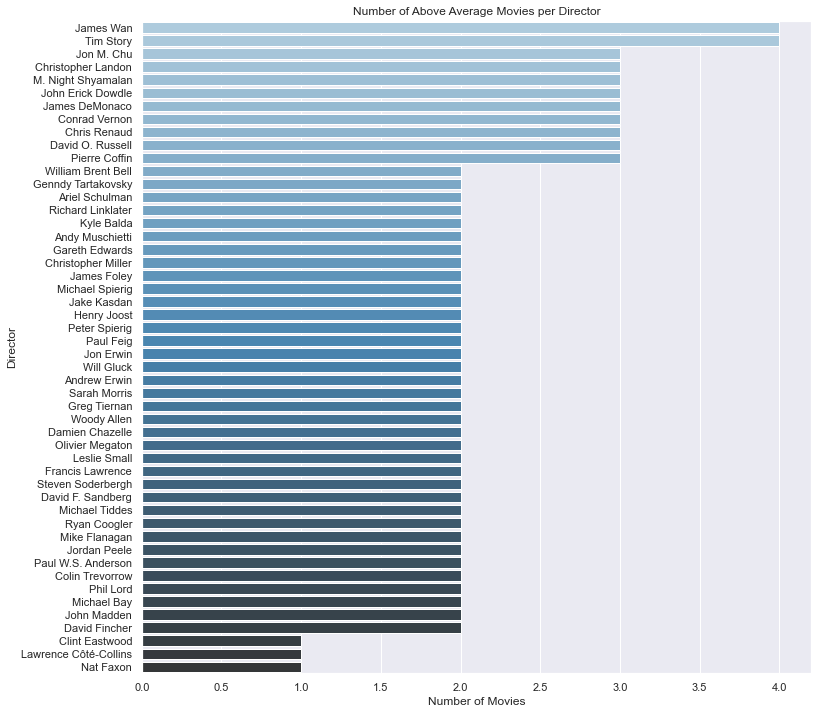

In [10]:
# Plot the 50 most successful names, and the number of movies of each director for above average movies.
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(12,12)})
ax = sns.barplot(x=aam_directors.values.tolist()[:50], y=aam_directors.index.tolist()[:50], palette="Blues_d")
ax.set_title('Number of Above Average Movies per Director')
ax.set_xlabel('Number of Movies')
ax.set_ylabel('Director');

Some unfamilar names there.This is because it's based on ROI, rather than gross revenue. So these guys get good bang for their buck.

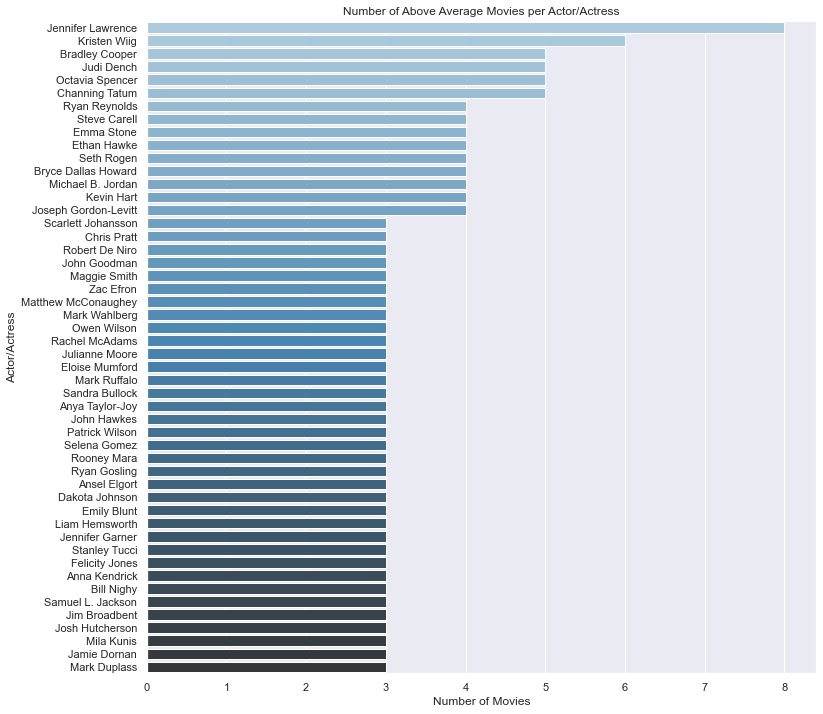

In [11]:
# Make the same series for actors and actresses.
aam_actor_actress = above_average_movies[(above_average_movies['category'] == 'actor') | \
                           (above_average_movies['category'] == 'actress')]['primary_name'].value_counts()

# let's look at the same sample for actors/actresses.
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(12,12)})
ax = sns.barplot(x=aam_actor_actress.values.tolist()[:50], y=aam_actor_actress.index.tolist()[:50], palette="Blues_d")
ax.set_title('Number of Above Average Movies per Actor/Actress')
ax.set_xlabel('Number of Movies')
ax.set_ylabel('Actor/Actress');

Now we'll do the same with poor performers. But we'll only take movies that had a relatively large budget, so we eliminate the movies that, due to low budget, never had a chance to begin with.

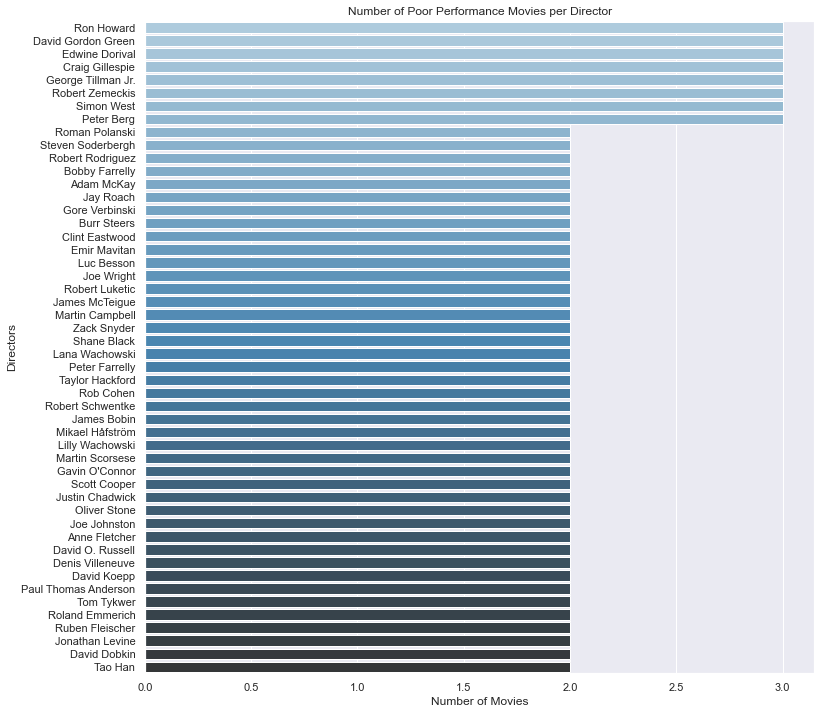

In [12]:
# Set the standard for poor performance movies at having a high budget and a low ROI.
poor_performance_movies = master_df[(master_df['ROI'] <= money_metrics_df['ROI'].median()) & \
          (master_df['production_budget'] >= money_metrics_df['production_budget'].median())]

# Take all the directors from the poor performing movies.
ppm_directors = poor_performance_movies[(poor_performance_movies['category'] == 'director')]['primary_name'].value_counts()

# Plot the 50 least successful names and the number of movies for each director for poor performing movies.
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(12,12)})
ax = sns.barplot(x=ppm_directors.values.tolist()[:50], y=ppm_directors.index.tolist()[:50], palette="Blues_d")
ax.set_title('Number of Poor Performance Movies per Director')
ax.set_xlabel('Number of Movies')
ax.set_ylabel('Directors');

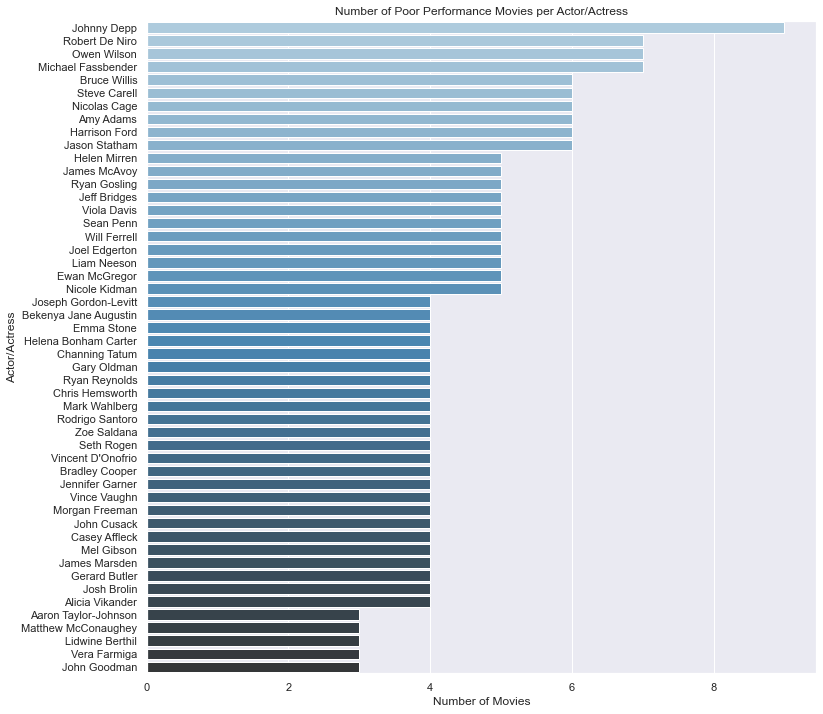

In [13]:
# Continue the same process for actors/actresses in poor prformance movies.
ppm_actor_actress = poor_performance_movies[(poor_performance_movies['category'] == 'actor') | \
                           (poor_performance_movies['category'] == 'actress')]['primary_name'].value_counts()

sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(12,12)})
ax = sns.barplot(x=ppm_actor_actress.values.tolist()[:50], y=ppm_actor_actress.index.tolist()[:50], palette="Blues_d")
ax.set_title('Number of Poor Performance Movies per Actor/Actress')
ax.set_xlabel('Number of Movies')
ax.set_ylabel('Actor/Actress');

Now we'll check to see if the directors, as well as the actors, of the really successful movies also made failed movies.

In [14]:
# Use ".intersection" to check how many of the successful movie directors, also directed failed movies.
num_dirs_with_good_bad = len(set(ppm_directors.index.tolist()).intersection( aam_directors.index.tolist()))
# Check what percent of good movie directors have also directed bad movies.
per_good_dirs_with_bad = round(num_dirs_with_good_bad/len(aam_directors)*100, 2)

# Use ".intersection" to check how many of the successful movie actors, also acted in failed movies.
num_acts_with_good_bad = len(set(aam_actor_actress.index.tolist()).intersection(ppm_actor_actress.index.tolist()))
# Check what percent of good movie actors have also acted in  bad movies.
per_good_acts_with_bad = round(num_acts_with_good_bad/len(aam_actor_actress)*100, 2)

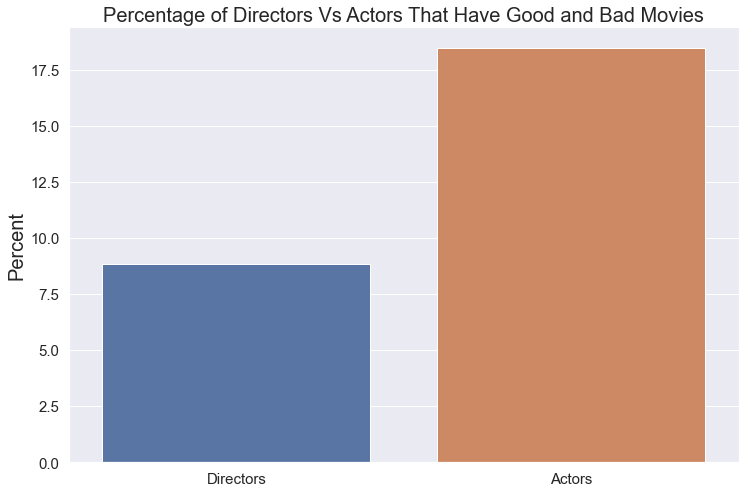

In [15]:
# Plot the difference between the percentages.
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(12,8)})
ax = sns.barplot(x=['Directors', 'Actors'], y=[per_good_dirs_with_bad, per_good_acts_with_bad])
ax.set_title('Percentage of Directors Vs Actors That Have Good and Bad Movies', size=20)
ax.set_ylabel('Percent', size=20)
ax.set_xticklabels(labels=['Directors', 'Actors'], size=15)
ax.set_yticklabels(ax.get_yticks(), size=15);

We see that the director of a movie will have a bigger impact on its success than the actors.

Lets see if when we filter our above_average_movies to be only big films, if the results will be any different. Lets say that we're only going to look at movies that have higher than the median production budgets.

In [16]:
# Add the condition that the production budget needs to be bigger than the median.
bm_above_average_movies = master_df[(master_df['ROI'] >= money_metrics_df['ROI'].mean()) &\
                                   (master_df['production_budget'] >= money_metrics_df['production_budget'].median())]

aa_big_movie_directors = bm_above_average_movies[(bm_above_average_movies['category'] == 'director')]\
                         ['primary_name'].value_counts()

bm_aam_actor_actress = bm_above_average_movies[(bm_above_average_movies['category'] == 'actor') | \
                    (bm_above_average_movies['category'] == 'actress')]['primary_name'].value_counts()

In [17]:
# Use ".intersection" to check how many of the successful movie directors, also directed failed movies.
bm_num_dirs_with_good_bad = len(set(aa_big_movie_directors.index.tolist()).intersection(ppm_directors.index.tolist()))
# Check what percent of good movie directors have also directed bad movies.
bm_per_good_dirs_with_bad = round(num_dirs_with_good_bad/len(aa_big_movie_directors)*100, 2)

# Use ".intersection" to check how many of the successful movie actors, also acted in failed movies.
bm_num_acts_with_good_bad = len(set(bm_aam_actor_actress.index.tolist()).intersection(ppm_actor_actress.index.tolist()))
# Check what percent of good movie actors have also acted in  bad movies.
bm_per_good_acts_with_bad = round(num_acts_with_good_bad/len(bm_aam_actor_actress)*100, 2)

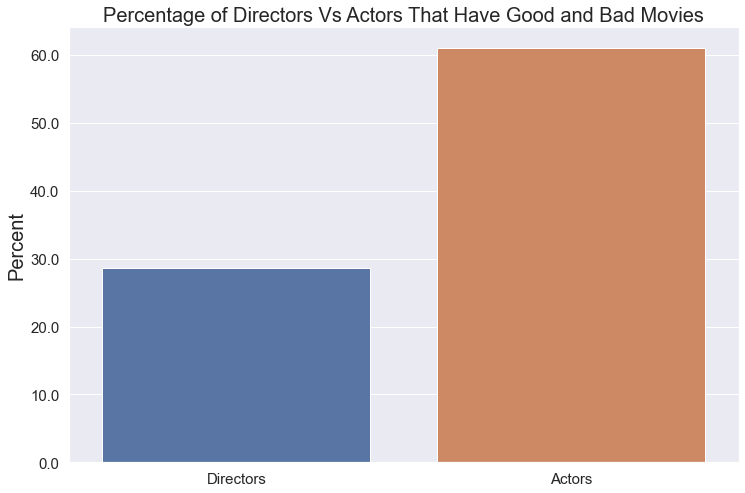

In [18]:
# Plot the difference between the percentages.
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(12,8)})
ax = sns.barplot(x=['Directors', 'Actors'], y=[bm_per_good_dirs_with_bad, bm_per_good_acts_with_bad])
ax.set_title('Percentage of Directors Vs Actors That Have Good and Bad Movies', size=20)
ax.set_ylabel('Percent', size=20)
ax.set_xticklabels(labels=['Directors', 'Actors'], size=15)
ax.set_yticklabels(ax.get_yticks(), size=15);

As expected, when we make take less data the differences get bigger.

We can conclude from our exploring, that it probably isn't wise to chase after the most expensive actors or actresses, since we see that many of them who have done really successful movies, have also done movies that did not perform well. 
For the directors, it seems that they definetely have a significant impact on the ROI. However there still is plenty of overlap for the directors as well, so our recommedation would be not to overpay for specific directors and definitely not actors. Rather focus on the other variables that have greater impact.